In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from poker_utils.constants import HANDS_DICT
from poker_utils.model import analyze_embeddings, save_model_and_embeddings, plot_train_loss, prob_embeddings

In [22]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")

In [23]:
equity_cols = [
    'tot_win_perc', 'high_card_win_perc', 'one_pair_win_perc', 
    'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential'
    ]

blocker_cols = [
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score'
       ]

base_cols = [
    'suited', 'pair', 'ace', 'broadway_score', 
    'low_pair', 'medium_pair', 'high_pair', 
    'suited_broadway_score', 
    'connector', 'one_gap', 'two_gap', 
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score'
    ]

In [24]:
full_data = pd.concat(
    [base_data[base_cols], 
     blocker_data[blocker_cols], 
     equity_data[equity_cols], 
     ev_data], axis=1)

In [25]:
handhand_data = pd.read_csv("data/processed/handhand_equity.csv")
handhand_data['equity_diff'] = handhand_data.hand1_equity - handhand_data.hand2_equity
handhand_data['equity_bin'] = pd.cut(handhand_data['equity_diff'], bins=10, labels=False)

In [26]:
class EquityDiffDataset:
    def __init__(self, feature_data, handhand_equity, train=None):
        self.train = train
        self.hands = feature_data.index
        self.feature_data = feature_data
        if train is not None:
            train_data, val_data = train_test_split(
                handhand_equity,
                test_size=0.3, 
                stratify=handhand_equity['equity_bin'],
                random_state=29
                )

            if train == True: 
                self.data = train_data
            elif train == False:
                self.data = val_data
        else:
            self.data = feature_data
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.train is not None:
            row = self.data.iloc[idx]
            hand1 = row['hand1']
            hand2 = row['hand2']
            hand1_features = self.feature_data.loc[hand1].to_numpy()
            hand2_features = self.feature_data.loc[hand2].to_numpy()
            equity_diff = row['equity_diff']

            return (
                torch.tensor(hand1_features, dtype=torch.float32),
                torch.tensor(hand2_features, dtype=torch.float32),
                torch.tensor(equity_diff, dtype=torch.float32)
            )
        else:
            return torch.tensor(self.data.iloc[idx].to_numpy(), dtype=torch.float32)
        

In [27]:
train_dataset = EquityDiffDataset(full_data, handhand_data, train=True)
val_dataset = EquityDiffDataset(full_data, handhand_data, train=False)
full_dataset = EquityDiffDataset(full_data, handhand_data)

In [28]:
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
valloader = DataLoader(val_dataset, shuffle=False, batch_size=128)
fullloader = DataLoader(full_dataset, shuffle=False, batch_size=len(full_dataset))

In [ ]:
class EquityDiffModel(nn.Module):
    def __init__(self, input_size=90, embedding_dim=8, hidden_dim=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, embedding_dim)
        )
        
        self.comparison = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
    
    def forward(self, hand1, hand2):
        emb1 = self.encoder(hand1)
        emb2 = self.encoder(hand2)
        combined = torch.cat([emb1, emb2], dim=1)
        equity_diff = self.comparison(combined)
        return emb1, emb2, equity_diff

In [30]:
def train_equity_model(model, trainloader,  valloader,  equity_loss_func,  optimizer,  epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for hand1_feat, hand2_feat, equity_diff in trainloader:
            optimizer.zero_grad()
            equity_diff = equity_diff.unsqueeze(1)
            emb1, emb2, pred_diff = model(hand1_feat, hand2_feat)
            equity_loss = equity_loss_func(pred_diff, equity_diff)
            
            equity_loss.backward()
            optimizer.step()
            tot_train_loss += equity_loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for hand1_feat, hand2_feat, equity_diff in valloader:
                equity_diff = equity_diff.unsqueeze(1)
                emb1, emb2, pred_diff = model(hand1_feat, hand2_feat)
                equity_loss = equity_loss_func(pred_diff, equity_diff)
                tot_val_loss += equity_loss.item()
            avg_val_loss = tot_val_loss / len(trainloader)
            val_losses.append(avg_val_loss)
            
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses

In [31]:

equity_model = EquityDiffModel(input_size=96, embedding_dim=16)
optimizer = torch.optim.Adam(params=equity_model.parameters(), lr=0.001)
equity_loss_func = nn.MSELoss()


Epoch 1/15, Train Loss: 0.0333, Val Loss: 0.0115
Epoch 4/15, Train Loss: 0.0108, Val Loss: 0.0093
Epoch 7/15, Train Loss: 0.0098, Val Loss: 0.0114
Epoch 10/15, Train Loss: 0.0086, Val Loss: 0.0094
Epoch 13/15, Train Loss: 0.0080, Val Loss: 0.0059
Epoch 15/15, Train Loss: 0.0077, Val Loss: 0.0096


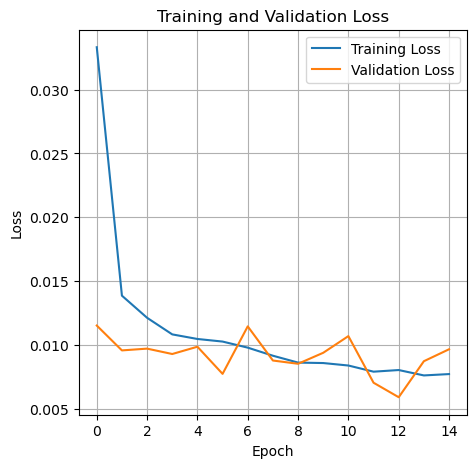

In [32]:
equity_train_losses, equity_val_losses = train_equity_model(
    equity_model, 
    trainloader, 
    valloader, 
    equity_loss_func, 
    optimizer,
    epochs=15
    )

plot_train_loss(equity_train_losses, equity_val_losses)


In [33]:
all_hands = next(iter(fullloader))
equity_model.eval()
with torch.no_grad():
    equity_emb = equity_model.encoder(all_hands)
    equity_emb = F.normalize(equity_emb, p=2, dim=1)

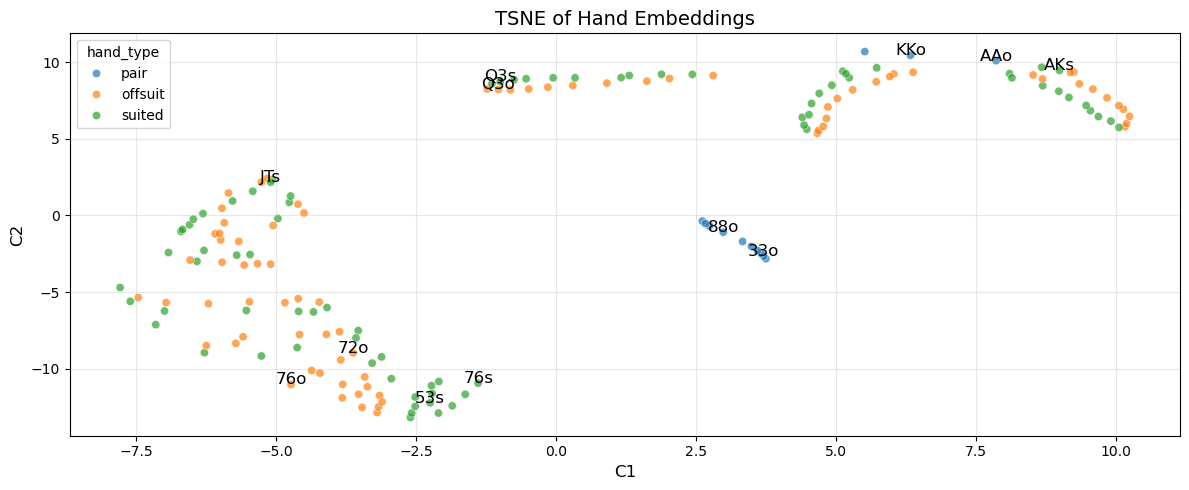

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9275)  AQs (0.9187)  AJs (0.8635)  T2o (-0.8108)   
1   KKo  QQo (0.9369)  AAo (0.9275)  KQs (0.8781)  94o (-0.8191)   
2   72o  73o (0.9940)  83o (0.9736)  82o (0.9727)  K9s (-0.8564)   
3   76s  65s (0.9666)  75s (0.9589)  74s (0.9439)  K9o (-0.7621)   
4   76o  75o (0.9545)  65o (0.9528)  74o (0.9396)  K9o (-0.8240)   
5   Q3s  Q2s (0.9974)  Q4s (0.9960)  Q4o (0.9907)  55o (-0.7143)   
6   Q3o  Q4o (0.9980)  Q2o (0.9970)  Q2s (0.9943)  33o (-0.7425)   
7   88o  99o (0.9536)  77o (0.9433)  TTo (0.8952)  Q4o (-0.5049)   
8   JTs  J9s (0.9936)  J9o (0.9835)  JTo (0.9778)  54o (-0.8119)   
9   33o  44o (0.9867)  22o (0.9846)  55o (0.9552)  Q8o (-0.8012)   
10  AKs  AQo (0.9899)  AKo (0.9869)  AQs (0.9826)  95o (-0.7496)   
11  53s  52s (0.9935)  63s (0.9919)  42s (0.9904)  K9s (-0.7819)   

         bottom_2       bottom_3  
0   92o (-0.8176)  93o (-0.8190)  
1   93o (-0.8314)  92o (-0.8397)  
2   KJo (-

In [34]:
similarity_df = analyze_embeddings(
    equity_emb, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

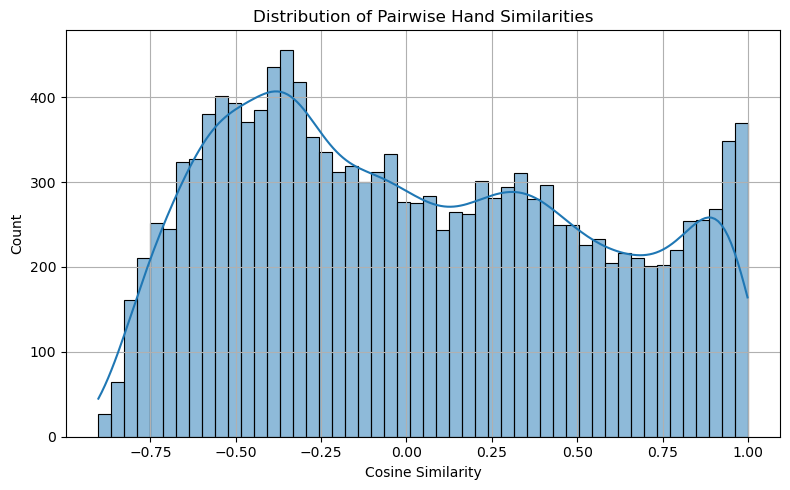

In [35]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [39]:
prob_res = prob_embeddings(equity_emb, prob_data)

In [40]:
prob_res[prob_res.attribute == 'suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
0,suited,0,0.994083,0.98913,1.000000,0.994536,0.538462,NaN
1,suited,1,0.994083,1.00000,0.987179,0.993548,0.461538,NaN


In [41]:
prob_res[prob_res.attribute == 'connectedness']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
2,connectedness,0,0.781065,1.000000,1.000000,1.000000,0.076923,NaN
3,connectedness,1,0.781065,0.866667,1.000000,0.928571,0.153846,NaN
4,connectedness,2,0.781065,0.869565,0.833333,0.851064,0.142012,NaN
5,connectedness,3,0.781065,0.950000,0.863636,0.904762,0.130178,NaN
6,connectedness,4,0.781065,0.947368,0.900000,0.923077,0.118343,NaN
7,connectedness,5,0.781065,0.750000,0.833333,0.789474,0.106509,NaN
8,connectedness,6,0.781065,0.615385,0.500000,0.551724,0.094675,NaN
9,connectedness,7,0.781065,0.400000,0.400000,0.400000,0.059172,NaN
10,connectedness,8,0.781065,0.375000,0.375000,0.375000,0.047337,NaN
11,connectedness,9,0.781065,0.333333,0.500000,0.400000,0.035503,NaN


In [42]:
prob_res[prob_res.attribute == 'pair']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
14,pair,0,1.0,1.0,1.0,1.0,0.923077,NaN
15,pair,1,1.0,1.0,1.0,1.0,0.076923,NaN


In [43]:
prob_res[prob_res.attribute == 'broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
60,broadway,0,0.988166,1.0000,1.0000,1.0000,0.378698,NaN
61,broadway,1,0.988166,0.9875,0.9875,0.9875,0.473373,NaN
62,broadway,2,0.988166,0.9600,0.9600,0.9600,0.147929,NaN


In [45]:
prob_res[prob_res.attribute == 'connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
72,connector,0,0.982249,0.986111,0.993007,0.989547,0.846154,NaN
73,connector,1,0.982249,0.960000,0.923077,0.941176,0.153846,NaN


In [ ]:
# prob_res.to_csv("results/prob_preflop_equitydiff16.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv(
#     "results/sim_preflop_equitydiff16.csv", index=False)

In [ ]:
# save_model_and_embeddings(
#     equity_emb,
#     'preflop_embeddings_equitydiff',
#     equity_model,
#     "preflop_equitydiff_encoder_weights"
#     )